## Задание 1

In [239]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [240]:
df = pd.read_excel("test_case_data_analyst.xlsx")
df

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657
...,...,...,...,...,...
114195,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8291100
114196,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936
114197,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910
114198,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146


### Задача 1

In [241]:
df.agg(min_date=('purchase_date', 'min'), max_date=('purchase_date', 'max'))

,purchase_date
min_date,2020-01-01
max_date,2020-02-20


In [242]:
df.query("user_id == 9484222")

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
101895,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222


In [243]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

custom_weeks = [pd.Timestamp('2019-12-31'), 
                pd.Timestamp('2020-01-07'),
                pd.Timestamp('2020-01-14'), 
                pd.Timestamp('2020-01-21'),
                pd.Timestamp('2020-01-28'),
                pd.Timestamp('2020-02-05'), 
                pd.Timestamp('2020-02-12'),
                pd.Timestamp('2020-02-19'),
                pd.Timestamp('2020-02-26')]

cohort_dates = df.groupby("user_id").agg({"purchase_date": "min"}).reset_index()

cohort_dates['week_origins'] = pd.cut(cohort_dates['purchase_date'], bins=custom_weeks, labels=[i+1 for i in range(len(custom_weeks)-1)])

cohort_dates = cohort_dates.drop("purchase_date", axis=1)

df = df.merge(cohort_dates, on='user_id')

df['week_cohorts'] = pd.cut(df['purchase_date'], bins=custom_weeks, labels=[i+1 for i in range(len(custom_weeks)-1)])

df['weeks_from_before'] = df['week_cohorts'].astype(int) - df['week_origins'].astype(int)

df['resubscribed_users'] = [1 if x > 0 else 0 for x in df['weeks_from_before']]

cohort_table = df.groupby('week_cohorts').agg(mrr=('quantity', 'sum'), users=('user_id', 'nunique'), resubscribed=('resubscribed_users', 'sum'))

cohort_table['shifted_users'] = cohort_table['users'].shift(1).fillna(0)

cohort_table['ltv'] = ((cohort_table['mrr'] / cohort_table['users']) / ((cohort_table['shifted_users'] - cohort_table['resubscribed']) / cohort_table['shifted_users'])).fillna(0).round(3)

# cohort_table = cohort_table.drop(['mrr', 'users', 'resubscribed', 'shifted_users'], axis=1).reset_index()

cohort_table['week_cohorts'] = custom_weeks[:-1]

cohort_table

C:\Users\User\AppData\Local\Temp\ipykernel_5424\1243486066.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_table = df.groupby('week_cohorts').agg(mrr=('quantity', 'sum'), users=('user_id', 'nunique'), resubscribed=('resubscribed_users', 'sum'))


,mrr,users,resubscribed,shifted_users,ltv,week_cohorts
week_cohorts,,,,,,
1,9194,9178,0,0.0,0.000,2019-12-31
2,12072,12054,3390,9178.0,1.588,2020-01-07
3,14734,14722,5664,12054.0,1.888,2020-01-14
4,15625,15602,7832,14722.0,2.140,2020-01-21
5,21075,19649,10381,15602.0,3.205,2020-01-28
6,19945,19927,10836,19649.0,2.232,2020-02-05
7,20630,20616,12067,19927.0,2.537,2020-02-12
8,925,925,670,20616.0,1.034,2020-02-19


### Задача 2

In [244]:
ltv_series = cohort_table['ltv']

model = ExponentialSmoothing(ltv_series, seasonal='add', seasonal_periods=7, initialization_method='known', initial_seasonal=([1.0] * 7), initial_level=ltv_series.iloc[0])
results = model.fit()
forecast_values = results.forecast(steps=26)

forecast_values.head()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


8     2.521029
9     2.394081
10    2.308210
11    2.665112
12    1.839968
dtype: float64

### Задача 3

In [245]:
forecast_df = pd.DataFrame({'week_cohorts': pd.date_range(start='2020-02-26', periods=26, freq='W-wed'), 'ltv': forecast_values})
forecast_df.head()

,week_cohorts,ltv
8,2020-02-26,2.521029
9,2020-03-04,2.394081
10,2020-03-11,2.308210
11,2020-03-18,2.665112
12,2020-03-25,1.839968


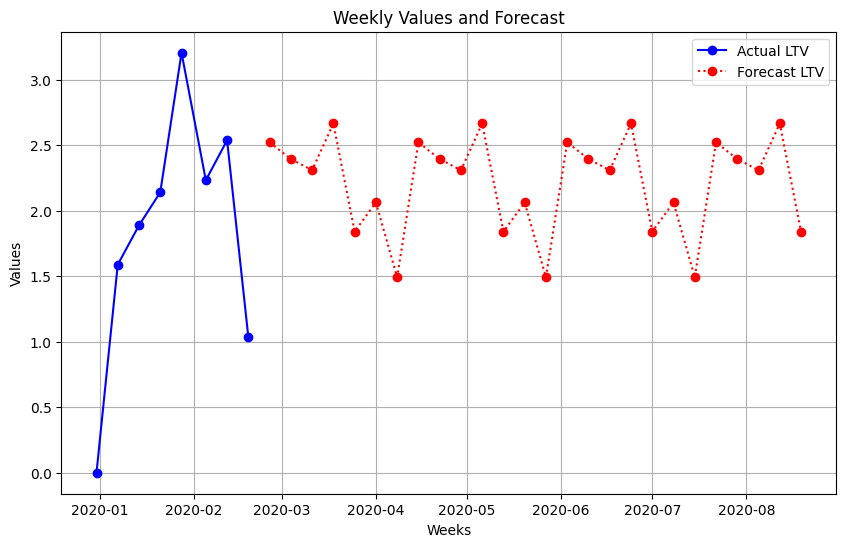

In [246]:

plt.figure(figsize=(10, 6))

plt.plot(cohort_table.week_cohorts, cohort_table['ltv'], label='Actual LTV', color='blue', marker='o')

plt.plot(forecast_df.week_cohorts, forecast_df['ltv'], label='Forecast LTV', linestyle='dotted', color='red', marker='o')

plt.title('Weekly Values and Forecast')
plt.xlabel('Weeks')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### Задача 4

In [248]:
forecast_df['romi'] = ((forecast_df.ltv * 4.99) - 6.00) / 6.00 * 100
forecast_df.head()

,week_cohorts,ltv,romi
8,2020-02-26,2.521029,109.665593
9,2020-03-04,2.394081,99.107755
10,2020-03-11,2.308210,91.966168
11,2020-03-18,2.665112,121.648463
12,2020-03-25,1.839968,53.023980


Давайте посчитаем ROMI относительно следующих 4х недель.

In [253]:
forecast_df[:4].romi.mean().round(1)

105.6

Теперь расчитаем ROMI относитльно полугода.

In [254]:
forecast_df.romi.mean().round(1)

84.2

Как мы видим за следующие 4 недели, ROMI показывает что маректинговые расходы окупятся на небольшой процент в 5. \
6%. В то время как за следующие полгода продукт потерят 15% на маркетинговых затрат.